In [1]:
'''
Date: 2022/Dec/23
Author: Yike Xie
Content: Create the fluorescent matrix of FAD according to existing publications
'''

'\nDate: 2022/Dec/23\nAuthor: Yike Xie\nContent: Create the fluorescent matrix of FAD according to existing publications\n'

In [2]:
# paper: https://archiv.ub.uni-marburg.de/diss/z2007/0482/pdf/drmv.pdf

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import seaborn as sns

In [4]:
wls =np.array([
 (325, 414),
 (343, 414),#
 (370, 414),
 (343, 451),
 (370, 451),
 (373, 451),
 (343, 575),#
 (393, 575),
 (406, 575),
 (441, 575),
 (400, 594),
 (406, 594),
 (431, 594),
 (480, 594),#
 (339, 575),
])

In [5]:
fmt_fn = '/home/yike/phd/cancer_cells_img_seq/scripts/spetra_matrixs/FAD2.png'
rgba_image = PIL.Image.open(fmt_fn)
rgb_image = rgba_image.convert('RGB')
rgb_image.save('/home/yike/phd/cancer_cells_img_seq/scripts/spetra_matrixs/FAD3.png')

(-0.5, 718.5, 343.5, -0.5)

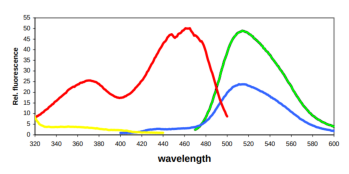

In [6]:
fmt_fn = '/home/yike/phd/cancer_cells_img_seq/scripts/spetra_matrixs/FAD3.png'
# load as a RGB image
fmt = plt.imread(fmt_fn)
fmt *= 255
fmt = fmt.astype(int)

plt.imshow(fmt)
plt.axis('off')

# red (255, 0, 0)
# blue (0, 0, 255)
# white (255, 255, 255)
# black (0, 0, 0)

In [13]:
w = fmt.shape[1]
l = fmt.shape[0]

R = ((fmt[:, :, 0] > 180) & (fmt[:, :, 1] < 50) & (fmt[:, :, 2] < 50)) # excitation red
B = ((fmt[:, :, 0] < 50) & (fmt[:, :, 1] > 180) & (fmt[:, :, 2] < 50)) # emission green
K = ((fmt[:, :, 0] < 50) & (fmt[:, :, 1] < 50) & (fmt[:, :, 2] <50))

# center
cx = pd.Series(fmt[:, :, :].sum(axis=2).sum(axis=0), index=range(w)).sort_values().index[0] # x axis 70
cy = pd.Series(fmt[:, :, :].sum(axis=2).sum(axis=1), index=range(l)).sort_values().index[0] # y axis 214

# x axis, max
x = pd.Series(fmt[:, :, :].sum(axis=2)[cy, :], index=range(w))
# xmin = x[x < 100].index[0]
xmax = x[x < 150].index[-1]

# axis, min
y = pd.Series(fmt[:, :, :].sum(axis=2)[:, cx], index=range(l))
ymin = y[y < 100].index[0]  # upper
# ymax = y[y < 100].index[-1] # lower

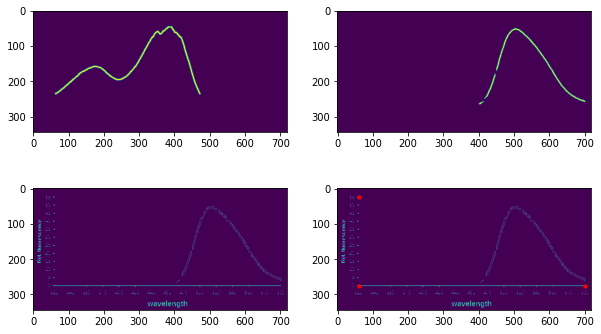

In [14]:
fig, axs = plt.subplots(2, 2, figsize=[10, 6])
axs[0, 0].imshow(R)
axs[0, 1].imshow(B) 
axs[1, 0].imshow(K)

axs[1, 1].imshow(K)
axs[1, 1].scatter(cx, cy, c='red', s=10)
axs[1, 1].scatter(cx, ymin, c='red', s=10)
axs[1, 1].scatter(xmax, cy, c='red', s=10)

In [15]:
ems = np.argwhere(B) # [y, x] [:, 1] x, [:, 0] y
exs = np.argwhere(R)

# emission wavelengths and fluorescent intensity
imin, imax = 0, 55
wmin, wmax = 320, 600
em_its = {(x - cx) * (wmax - wmin) / (xmax - cx) + wmin : (imax - imin) * (cy - y) / (cy - ymin) + imin 
              for y, x  in ems} # 400 - 550
ex_its = {(x - cx) * (wmax - wmin) / (xmax - cx) + wmin : (imax - imin) * (cy - y) / (cy - ymin) + imin 
              for y, x  in exs}# 280 - 380

# emission wavelengths and fluorescent ratio
em_it_max = max(em_its.values())
ex_it_max = max(ex_its.values())

import math
em_ratio = {round(k, 1): v / em_it_max for k, v in em_its.items()}
ex_ratio = {round(k, 1): v / ex_it_max for k, v in ex_its.items()}

Text(0, 0.5, 'Fluorescent intensity')

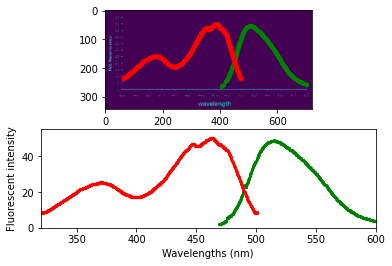

In [18]:
fig, axs = plt.subplots(2)

axs[0].imshow(K)
axs[0].scatter(ems[:, 1], ems[:, 0], color='green', s=5)
axs[0].scatter(exs[:, 1], exs[:, 0], color='red', s=5)

axs[1].set_xlim(wmin, wmax)
axs[1].set_ylim(imin, imax)
axs[1].scatter(em_its.keys(), em_its.values(), color='green', s=5)#
axs[1].scatter(ex_its.keys(), ex_its.values(), color='red', s=5)#
axs[1].set_xlabel('Wavelengths (nm)')
axs[1].set_ylabel('Fluorescent intensity')

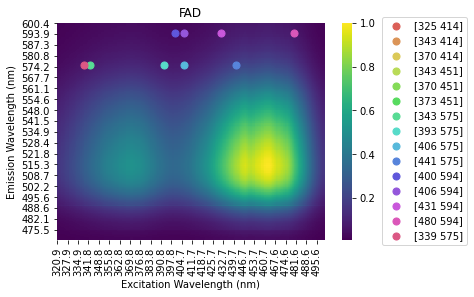

In [19]:
name = 'FAD'
columns = list(ex_ratio.keys())
columns.sort()
index = list(em_ratio.keys())
index.sort()
index = index[::-1]

df = pd.DataFrame(np.zeros(shape=(len(index), len(columns))), 
                      index=index, columns=columns)

for x in ex_ratio.keys():
    for y in em_ratio.keys():
        df.at[y, x] = ex_ratio[x] * em_ratio[y]

fdn = '/home/yike/phd/cancer_cells_img_seq/scripts/spetra_matrixs/heatmap/'
df.to_csv(fdn + name + '_FL_ratio_matrix.tsv', sep='\t')

fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(df, cmap='viridis', ax=ax)
ax.set_xlabel('Excitation Wavelength (nm)')
ax.set_ylabel('Emission Wavelength (nm)')
ax.set_title(name)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
xmin, xmax = df.columns.min(), df.columns.max()
ymin, ymax = df.index.min(), df.index.max()
sx = [(i - xmin) * (xlim[1] - xlim[0]) / (xmax - xmin) + xlim[0] for i in wls[:, 0].tolist()]
sy = [(i - ymin) * (ylim[1] - ylim[0]) / (ymax - ymin) + ylim[0] for i in wls[:, 1].tolist()]

colors = sns.color_palette('hls', 15)
handles, labels = ax.get_legend_handles_labels()
for i, txt in enumerate(range(1, 16)):
    ax.scatter(sx[i], sy[i], color=colors[i], s=50)
    handles.append(ax.scatter([], [], color=colors[i], s=50)) 

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.legend(handles=handles, labels = [str(i) for i in wls], bbox_to_anchor=(1.55, 1.05))
plt.savefig(fdn + name + '.png', dpi=300, bbox_inches='tight')